In [11]:
%%capture
%run pre_processing.ipynb


In [12]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Load EfficientNet_B0

In [14]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)


In [15]:
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

In [16]:
for param in model.features.parameters():
    param.requires_grad = False
model = model.to(device)

Loss + Optimizer 

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Train One Epoch Function and Evaluation Function

In [18]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # وضع التدريب
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()          # تصفير التدرجات
        outputs = model(images)        # forward
        loss = criterion(outputs, labels)  # حساب الخسارة
        loss.backward()                # backprop
        optimizer.step()               # تحديث الأوزان

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)   # أعلى احتمال = الكلاس المتوقّع
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [19]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()   # وضع التقييم (يعطّل Dropout/BatchNorm updates)
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



Training Loop

In [20]:
num_epochs = 15  # كبداية، نقدر نغيرها بعدين
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train  -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val    -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # حفظ أفضل موديل بناءً على دقة الـ validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_b0_1.pth")

        print("  ✅ New best model saved!")

Epoch 1/15
  Train  -> Loss: 2.1234, Acc: 0.2520
  Val    -> Loss: 1.9243, Acc: 0.4119
  ✅ New best model saved!
Epoch 2/15
  Train  -> Loss: 1.8435, Acc: 0.4147
  Val    -> Loss: 1.7250, Acc: 0.5309
  ✅ New best model saved!
Epoch 3/15
  Train  -> Loss: 1.7075, Acc: 0.4632
  Val    -> Loss: 1.5852, Acc: 0.5652
  ✅ New best model saved!
Epoch 4/15
  Train  -> Loss: 1.6179, Acc: 0.5127
  Val    -> Loss: 1.4876, Acc: 0.5950
  ✅ New best model saved!
Epoch 5/15
  Train  -> Loss: 1.5296, Acc: 0.5275
  Val    -> Loss: 1.4096, Acc: 0.6064
  ✅ New best model saved!
Epoch 6/15
  Train  -> Loss: 1.4566, Acc: 0.5652
  Val    -> Loss: 1.3438, Acc: 0.6133
  ✅ New best model saved!
Epoch 7/15
  Train  -> Loss: 1.4027, Acc: 0.5838
  Val    -> Loss: 1.2614, Acc: 0.6453
  ✅ New best model saved!
Epoch 8/15
  Train  -> Loss: 1.3577, Acc: 0.5980
  Val    -> Loss: 1.2206, Acc: 0.6568
  ✅ New best model saved!
Epoch 9/15
  Train  -> Loss: 1.3080, Acc: 0.6152
  Val    -> Loss: 1.1833, Acc: 0.6751
  ✅ New b

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
import torch
from sklearn.metrics import confusion_matrix





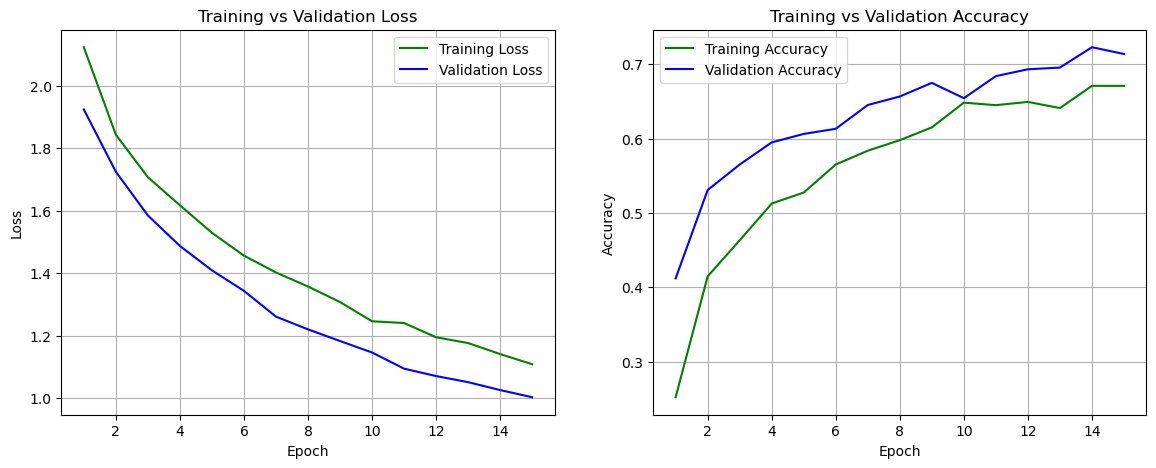

In [22]:
train_losses = [
    2.1234, 1.8435, 1.7075, 1.6179, 1.5296,
    1.4566, 1.4027, 1.3577, 1.3080, 1.2465,
    1.2409, 1.1953, 1.1768, 1.1416, 1.1090
]
val_losses = [
    1.9243, 1.7250, 1.5852, 1.4876, 1.4096,
    1.3438, 1.2614, 1.2206, 1.1833, 1.1466,
    1.0949, 1.0712, 1.0517, 1.0264, 1.0035
]
train_accuracies = [
    0.2520, 0.4147, 0.4632, 0.5127, 0.5275,
    0.5652, 0.5838, 0.5980, 0.6152, 0.6485,
    0.6451, 0.6495, 0.6412, 0.6711, 0.6711
]
val_accuracies = [
    0.4119, 0.5309, 0.5652, 0.5950, 0.6064,
    0.6133, 0.6453, 0.6568, 0.6751, 0.6545,
    0.6842, 0.6934, 0.6957, 0.7231, 0.7140
]


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()



Evaluation on Test Set

In [25]:
# تحميل أفضل أوزان للموديل
best_model = model  # نستخدم نفس الموديل اللي دربناه
state_dict = torch.load("best_efficientnet_b0_1.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

# تقييم على test_loader باستخدام نفس evaluate اللي عندك
test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 1.0256
Test Accuracy: 0.7374


In [28]:


# اختبري أفضل وزن عندك
best_model = model
state_dict = torch.load("best_efficientnet_b0_1.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        outputs = best_model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# اطبع التقرير ✨
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))



Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77        83
           1       0.66      0.57      0.61        61
           2       0.00      0.00      0.00         3
           3       0.68      0.63      0.65        51
           4       0.86      0.75      0.80        64
           5       0.00      0.00      0.00         2
           6       0.77      1.00      0.87        17
           7       0.80      0.86      0.83        80
           8       1.00      1.00      1.00         5
           9       0.61      0.72      0.66        65
          10       0.75      1.00      0.86         6
          11       0.00      0.00      0.00         1

    accuracy                           0.74       438
   macro avg       0.57      0.61      0.59       438
weighted avg       0.73      0.74      0.73       438



c:\Users\Njood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Njood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Njood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)

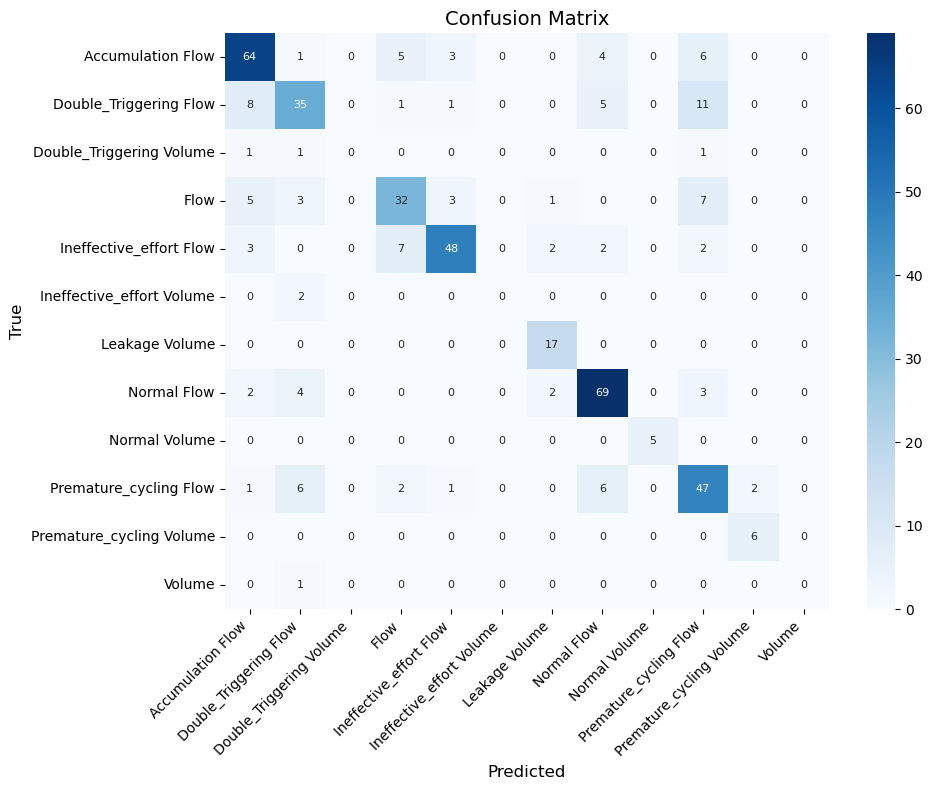

In [30]:



plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,          # يكتب الأرقام داخل المربعات
    fmt="d",             # أرقام صحيحة
    cmap="Blues",        # الألوان
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}   # حجم النص داخل المربعات
)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571

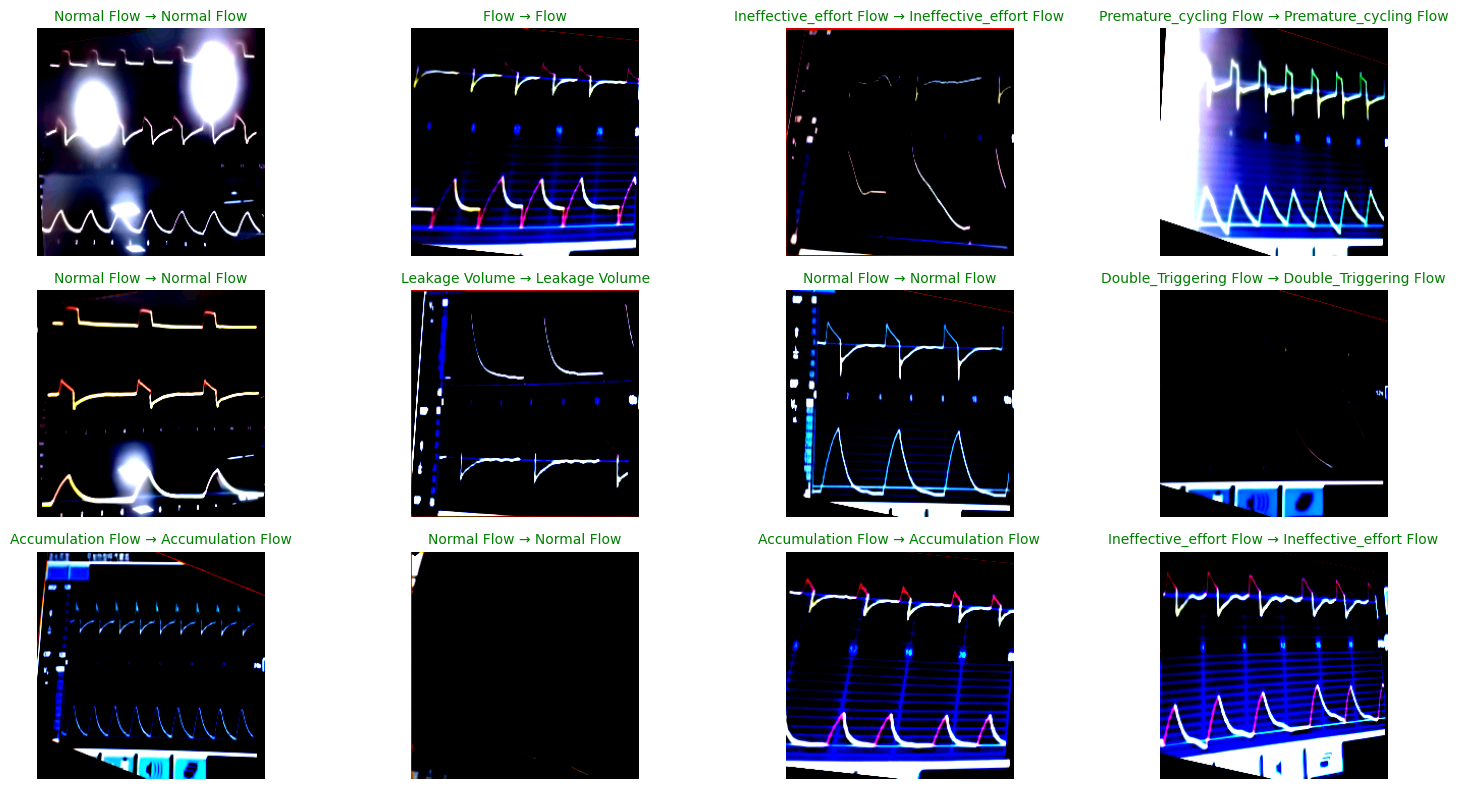

In [33]:
# %%
def show_predictions_grid(model, loader, class_names, device, num_images=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                # لو فيه Normalization ممكن تحتاجين ترجعينه [0,1] أو [0,255] حسب البريبروسيس

                label = labels[i].item()
                pred = preds[i].item()

                true_name = class_names[label]
                pred_name = class_names[pred]

                ax = plt.subplot(3, 4, images_shown + 1)
                ax.imshow(img)
                ax.axis("off")

                title = f"{true_name} → {pred_name}"
                color = "green" if label == pred else "red"
                ax.set_title(title, color=color, fontsize=10)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

show_predictions_grid(best_model, test_loader, CLASSES, device, num_images=12)
